# The Sky Team's Final Project: Analysis of _All About SFO_
#### By Trang Vu and Anthony Iorio

## This notebook explains what this project is, what it means, and what we did with it.

### First, some background on the name...

You might recognize our team name, "Sky Team," as being very similar to one of the world's leading airline alliances, SkyTeam. This isn't unintentional. We felt this was a great name for our project, as a tribute to our mutual love of aviation and interest in exploring the massive amount of data that was collected by San Francisco Airport Commission.

### About that data...

It's located [here](https://catalog.data.gov/dataset/air-traffic-passenger-statistics), and it's from San Francisco International Airport. The City of San Francisco, through its SFO Airport Commission, is responsible for the data we used.

### What's the point?

What we have here is an aviation enthusiast (or data scientist's) dream. We have over 17,500 rows of data, spanning over 12 years! In SFO alone, the airline industry has changed so much over that period of time that there will be plenty of observable trends derived from the metrics gleaned by SFOAC in this databank. There's even many airlines on that list who (sadly) no longer grace our skies...the consolidation of the airline industry from 2009-2015 has really left its mark. We even paired it up (or shall we say...JOINed...) it with another table relating to SFO airport data...more on that in a moment. Let's dive in!

### Import sqlite3, Pandas, and the ipython-sql (%sql) Jupyter extension...and a few more.

Like all great Jupyter notebooks, our project revolves around several Python modules that were essential for the proper excecution of our code. These were SQLite, Pandas, Numpy, MatPlotLib, Seaborn, GeoPy, Basemap, rgb2hex, Polygon, ScalarMappable, Colorbarbase, and Math. Just in case we need them later on, we might as well put them here.

In [12]:
# Here are all the modules we used.
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import rgb2hex
from matplotlib.patches import Polygon
from matplotlib.cm import ScalarMappable
from matplotlib.colorbar import ColorbarBase
import matplotlib as mpl
import math
import datetime as dt
%matplotlib inline

%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


### Connecting to the database

In [13]:
%sql sqlite:///airpassenger.db

'Connected: None@airpassenger.db'

## The Terminals

As you might imagine, terminal information is a crucially important part of air travel. Let's see what the contents look like by creating a dataframe.

In [37]:
airportterminal_rs = %sql None@airpassenger.db SELECT * FROM AIRPORTDIMENSION;
airportterminal = airportterminal_rs.DataFrame().set_index('AirportID')
airportterminal

Done.


,Terminal,BoardingArea
AirportID,,
1,Terminal 1,B
2,International,G
3,International,A
4,Terminal 3,E
5,Terminal 1,C
6,Terminal 1,A
7,Terminal 3,F
8,Other,Other
9,Terminal 2,D


In [15]:
#Joining the ACTIVITYDIMENSION  and PASSENGERFACT together and transfer to dataframe
airportterminal_rs = %sql None@airpassenger.db select ActivityType, sum(passengercount) from ACTIVITYDIMENSION JOIN PASSENGERFACT ON (ACTIVITYDIMENSION.ActivityID = PASSENGERFACT.ActivityID) group by ActivityType;
airportterminal = airportterminal_rs.DataFrame()
airportterminal


Done.


,ActivityType,sum(passengercount)
0,Deplaned,4237149699
1,Enplaned,4198255419
2,Thru / Transit,29143026


In [16]:
# transferring the airportdimension table to airportterminal_df: 
airportterminal = %sql select AIRPORTDIMENSION.terminal, sum(passengercount) as TotalPassenger from AIRPORTDIMENSION JOIN flightdata ON (flightdata.Terminal=AIRPORTDIMENSION.Terminal) group by AIRPORTDIMENSION.terminal;
airportterminal_df = airportterminal.DataFrame()
airportterminal_df

Done.


,Terminal,TotalPassenger
0,International,558514384
1,Other,400
2,Terminal 1,754275678
3,Terminal 2,92692294
4,Terminal 3,842081508


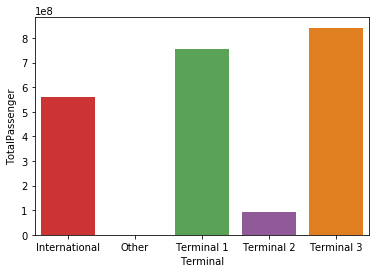

In [17]:
#creating a barchart to compare the total passenger between terminals:
ax = sns.barplot(y=airportterminal_df['TotalPassenger'], x=airportterminal_df['Terminal'], data=airportterminal_df,palette='Set1')
plt.show()

Looking at the chart, Terminal 3 has the highest total passenger usage during the 12-year period (842,081,508 passengers). It is somewhat close to with Terminal 1 (754,275,678). Terminal 2 was not utilized very heavily, with 92,692,294 passengers passing through over the course of this dataset. International terminals processed 558,514,384 passengers. If you continue on in the analysis and read the figures below that establish breakdown of flight type by Geographic Region, it's fairly clear this data is consistent with the "Flight Types by Destination at SFO."

### Let's look at passenger metrics.

In [38]:
#Joining TIMEDIMENSION and PASSENGERFACT tables and creating dataframe named Passengeryear
Passengeryear_rs = %sql select ActivityPeriod, sum(passengercount) as TotalPassenger from TIMEDIMENSION JOIN PASSENGERFACT ON (TIMEDIMENSION.TimeID = PASSENGERFACT.TimeID) group by ActivityPeriod;
Passengeryear = Passengeryear_rs.DataFrame()
#chaging data type of activityperiod
Passengeryear['ActivityPeriod'] = Passengeryear['ActivityPeriod'].astype('str')
Passengeryear['Date'] = Passengeryear['ActivityPeriod'].apply(lambda x: dt.datetime.strptime(x,'%Y%m'))



Done.


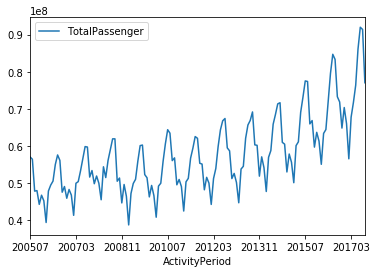

In [39]:
#creating a linechart to compare the total passenger in each year
Passengeryear = Passengeryear.set_index('ActivityPeriod')
Passengeryear.plot()

As you can see, total passenger volume has risen drastically with time. The role of the seasons (peak and non-peak intervals) is also made obvious with the line chart. Pretty neat!

### Now, let's see if we can consider the geographic dimensions of passenger activity.

In [20]:
# joining the PassengerFact and GeographicDimension tables, then creating a dataframe
Passengergeo_rs = %sql select GeoRegion, sum(passengercount) as TotalPassenger from GEOGRAPHICDIMENSION JOIN PASSENGERFACT ON (GEOGRAPHICDIMENSION.GeoID = PASSENGERFACT.GeoID) group by GeoRegion;
Passengergeo_df = Passengergeo_rs.DataFrame()
Passengergeo_df

Done.


,GeoRegion,TotalPassenger
0,Asia,727583292
1,Australia / Oceania,727583292
2,Canada,727583292
3,Central America,727583292
4,Europe,727583292
5,Mexico,727583292
6,Middle East,727583292
7,South America,727583292
8,US,2643881808


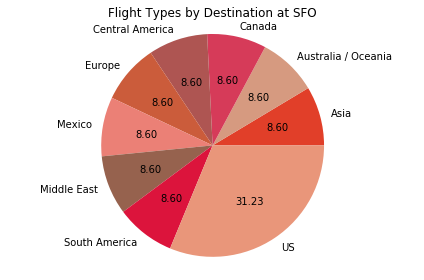

In [21]:
# Create a list of colors (from iWantHue)
colors = ["#E13F29", "#D69A80", "#D63B59", "#AE5552", "#CB5C3B", "#EB8076", "#96624E", "#DC143C", "#E9967A"]

# Create a pie chart
plt.pie(
    # using data TotalPassenger:
    Passengergeo_df['TotalPassenger'],
    # with the labels being the locations people flew to:
    labels=Passengergeo_df['GeoRegion'],
    # with no shadows:
    shadow=False,
    # with colors:
    colors=colors,
    # showing percentages:
    autopct='%.2f'
    )

# View the plot drop above
plt.axis('equal')

# Give it a title!
plt.title('Flight Types by Destination at SFO')

# View the plot
plt.tight_layout()
plt.show()

# This piechart was made different shades of red as a tribute to Northwest Airlines. You are missed, NW.

This pie chart clearly shows the distribution of flights that "touch" SFO (meaning, it satisfies one of the `ActivityTypeCode`s). The distribution is displayed above. However, there are several noticeable aspects about this data that we should touch on. The first observation is that while Domestic flights are the single largest segment of SFO's traffic; when compared with all International activity, it's roughly a 68.80/31.23 split. This reinforces the perception that SFO is a largely international airport, and uses concrete data to make that case. Additionally, you may find it curious that each region has exactly 8.60% share of flight activity at SFO. This is certainly not coincidential - it is by design that this is the case, as local, regional, and federal authorities regulate the allocation of capacity at SFO, and determine the assignment of (and ultimately issue approvals for) international routes. In this case, it is most certainly intentional, but the conequence of such legislative activity is usually observable in a pattern.

### Now, we'll merge the operating airport dimension with another dataset!

In [22]:
#taking the hosted csv file and creating the air-traffic-landings-statistics.csv
url = 'https://data.sfgov.org/api/views/fpux-q53t/rows.csv?accessType=DOWNLOAD'
from urllib.request import urlretrieve
urlretrieve(url, 'air-traffic-landings-statistics.csv')

('air-traffic-landings-statistics.csv',
 <http.client.HTTPMessage at 0x25452b541d0>)

In [23]:
import pandas as pd
# importing air-traffic-landings-statistics.csv into table called data
data = pd.read_csv('air-traffic-landings-statistics.csv')
data.head()

,Activity Period,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Landing Aircraft Type,Aircraft Body Type,Aircraft Manufacturer,Aircraft Model,Aircraft Version,Landing Count,Total Landed Weight
0,200507,ABX Air,GB,ABX Air,GB,Domestic,US,Freighter,Narrow Body,McDonnell Douglas,DC-9,30,40,4066000
1,200507,ABX Air,GB,ABX Air,GB,Domestic,US,Freighter,Narrow Body,McDonnell Douglas,DC-9,41,1,102000
2,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Passenger,Narrow Body,Boeing,757,200,2,396000
3,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Passenger,Narrow Body,Boeing,757,300,167,37408000
4,200507,Air Canada,AC,Air Canada,AC,International,Canada,Passenger,Wide Body,Boeing,767,333,1,320000


/* *** Transfering OPERATINGAIRDIMENSION into dataframe  *** */

In [24]:
operatingairline_rs = %sql None@airpassenger.db select * from OPERATINGAIRDIMENSION;
operatingairline = operatingairline_rs.DataFrame().set_index('OperatingID')


Done.


In [25]:
#merging two tables together which is operatingairline and data
airlanding = pd.merge(left=operatingairline,right=data,left_on='OperatingIATA',right_on='Operating Airline IATA Code')
airlanding.head()

,OperatingAirlineIdentifier,OperatingIATA,Activity Period,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Landing Aircraft Type,Aircraft Body Type,Aircraft Manufacturer,Aircraft Model,Aircraft Version,Landing Count,Total Landed Weight
0,ATA Airlines,TZ,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Passenger,Narrow Body,Boeing,757,200,2,396000
1,ATA Airlines,TZ,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Passenger,Narrow Body,Boeing,757,300,167,37408000
2,ATA Airlines,TZ,200508,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Passenger,Narrow Body,Boeing,737,800,1,146300
3,ATA Airlines,TZ,200508,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Passenger,Narrow Body,Boeing,757,200,3,594000
4,ATA Airlines,TZ,200508,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Passenger,Narrow Body,Boeing,757,300,159,35616000


In [26]:
#deleting all rows that have Landing Aircraft Type is Freighter
airline = airlanding[airlanding['Landing Aircraft Type'] != "Freighter"]
airline.head()

,OperatingAirlineIdentifier,OperatingIATA,Activity Period,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Landing Aircraft Type,Aircraft Body Type,Aircraft Manufacturer,Aircraft Model,Aircraft Version,Landing Count,Total Landed Weight
0,ATA Airlines,TZ,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Passenger,Narrow Body,Boeing,757,200,2,396000
1,ATA Airlines,TZ,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Passenger,Narrow Body,Boeing,757,300,167,37408000
2,ATA Airlines,TZ,200508,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Passenger,Narrow Body,Boeing,737,800,1,146300
3,ATA Airlines,TZ,200508,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Passenger,Narrow Body,Boeing,757,200,3,594000
4,ATA Airlines,TZ,200508,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Passenger,Narrow Body,Boeing,757,300,159,35616000


In [27]:
# checking to see which Aircraft Manufacturer is operated the most
airline['Aircraft Manufacturer'].value_counts()

Boeing               13820
Airbus                5655
Bombardier            1133
Embraer                586
McDonnell Douglas      473
DeHavilland             41
Lockheed                 5
Name: Aircraft Manufacturer, dtype: int64

In [28]:
# Now, let's put that in a DataFrame:
rd = airline['Aircraft Manufacturer'].value_counts()
df = pd.DataFrame(rd)

df

,Aircraft Manufacturer
Boeing,13820
Airbus,5655
Bombardier,1133
Embraer,586
McDonnell Douglas,473
DeHavilland,41
Lockheed,5


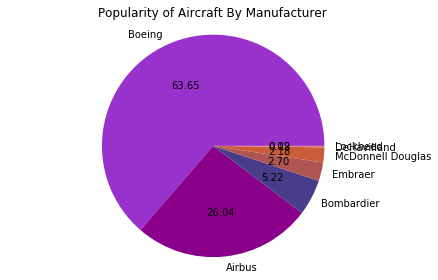

In [29]:
# Just as before...checking to see which Aircraft Manufacturer is operated the most
rd = airline['Aircraft Manufacturer'].value_counts()
df = pd.DataFrame(rd)

# Create a list of colors (from iWantHue)
colors = ["#9932CC", "#8B008B", "#483D8B", "#AE5552", "#CB5C3B", "#EB8076", "#96624E", "#DC143C", "#E9967A"]

# Create a pie chart
plt.pie(
    # using the number of aircraft operated by airlines, by brand:
    df['Aircraft Manufacturer'],
    # with the labels being the locations people flew to:
    labels=['Boeing','Airbus','Bombardier','Embraer','McDonnell Douglas','DeHavilland','Lockheed'], autopct='%.2f',
    # with no shadows
    shadow=False,
    # with colors
    colors=colors,
    )

# View the plot drop above
plt.axis('equal')

# Give it a title!
plt.title('Popularity of Aircraft By Manufacturer')

# View the plot
plt.tight_layout()
plt.show()

# Fun fact: Boeing's market dominance is even more pronounced if you consider the fact they acquired rival aircraft manufacturer McDonnell-Douglas.

When we wrap the data in a pie chart, Boeing's position of market dominance becomes even more obvious at 63.65%. As clearly demonstrated by the chart, even the combination of every single other one of its competitors amounts to only a collective 36.35% of equipment types at SFO, which seems surprising given the conventional notion that Airbus has made inroads in the US market against Boeing with the success of its A320 Family aircraft. It is also important to keep in mind that this is a cross-section of only SFO, not the entire US aviation industry, and at SFO they Boeing supremacy may also be due to the simple fact that Boeing-centric or Boeing-exclusive operators (such as United and Southwest, respectively) operate heavily out of this market. Therefore, the fleet allocation at SFO across all carriers is likely much more skewed toward Boeing than at other US airports. Another dimension to consider is that besides Airbus and McDonnell-Douglas (and the possible exceptions of Embraer and Bombardier), the manufacturers listed there tend to produce regional aircraft (turboprops and jets), and that Boeing tends not to compete in this segment, making the comparison unequal. Still, Boeing's market position is widely noted for its supremacy, so it should not be surprising that the results are the way they are (even if they are slightly more pronounced than at other airports).

In [30]:
#Counting which airlines make the most landing
Landing = airline.groupby(by='OperatingAirlineIdentifier')['Landing Count'].sum().sort_values()
Landing

OperatingAirlineIdentifier
Xtra Airways                                 1
World Airways                                3
Atlas Air, Inc                               7
Miami Air International                     11
BelAir Airlines                             33
Thomas Cook Airlines                        40
Finnair                                     52
Air Pacific Limited dba Fiji Airways        79
Allegiant Air                               88
Icelandair                                 119
Jet Airways                                181
XL Airways France                          204
Republic Airlines                          285
Spirit Airlines                            314
Independence Air                           318
WOW Air                                    364
Air India Limited                          428
Air Berlin                                 505
Volaris Airlines                           509
Atlantic Southeast Airlines                585
Air Canada Jazz                  

### Perhaps a DataFrame will make this a bit prettier to look at, no?

In [31]:
# Let's put that in a DataFrame:
#Counting which airlines make the most landing
Landing = airline.groupby(by='OperatingAirlineIdentifier')['Landing Count'].sum().sort_values()
Landing_PD = pd.DataFrame(Landing)
Landing_PD

,Landing Count
OperatingAirlineIdentifier,
Xtra Airways,1
World Airways,3
"Atlas Air, Inc",7
Miami Air International,11
BelAir Airlines,33
Thomas Cook Airlines,40
Finnair,52
Air Pacific Limited dba Fiji Airways,79
Allegiant Air,88


### Interesting stuff!